In [27]:
import EMGfiltersCONFIDENTIAL as EMGfilt
import h5py
from pathlib import Path
import numpy as np
import pandas as pd
import scipy.signal
from scipy.signal import welch, iirnotch, filtfilt, butter, lfilter, iirfilter
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import os
import matplotlib.tri as mtri
from scipy.interpolate import griddata
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.spatial import cKDTree
from scipy.ndimage import gaussian_filter
import warnings
import seaborn as sns

%run feature_extractor.ipynb


In [28]:
# Calling in .csv file that notes bad channels to throw out

baseDir = Path("/Volumes/LaCie/ResearchProjects/Null_Space_EMG")
outDir  = baseDir / "preprocessing"
noisy_path = outDir / "noisy_channels.csv"  # adjust if stored elsewhere

if noisy_path.exists():
    noisy_df = pd.read_csv(noisy_path)
    noisy_df["SubjectID"] = noisy_df["SubjectID"].astype(str)
    noisy_df["Day"]       = noisy_df["Day"].astype(int)
    noisy_df["Trial"]     = noisy_df["Trial"].astype(int)
else:
    noisy_df = pd.DataFrame(
        columns=["SubjectID","Day","Task","Trial","Channel","Muscle","SNR","RMS","RMS_z","Info"]
    )


In [ ]:
# ---------------- CONFIG ----------------
baseDir = Path("/Volumes/LaCie/ResearchProjects/Null_Space_EMG")
outDir  = baseDir / "preprocessing"
outDir.mkdir(parents=True, exist_ok=True)

subs   = ['16','17','18','19','20','21',] #['07','08','09','10','11','12','13','14','15']
days   = ["1","2","3","4","5"]
tasks  = ["Tapes","Tapes_standing","Tapes_cog_load"]   # adjust as needed
trials = range(1, 5+1)

dataset_name   = "rawEMG"
fs             = 2000
lowcut         = 20
highcut        = 500
envelopecut    = 2
chanNumb       = 64
down_win       = 200       # envelope “squish”: every 200 samples
threshold_frac = 0.2       # burst threshold = this * per-channel max(|envelope|)
# define bands for band energy (Hz)
bands = [(20.0, 60.0), (60.0, 120.0), (120.0, 250.0)]

# features you care about for learning
feat_names = [
    "RMS",      # amplitude / effort
    "MNF",      # mean frequency
    "MDF",      # median frequency
    "PKF",      # peak frequency
    "IEMG",     # integrated EMG
    "VAR",      # variance
    # channel-based features you requested
    "ZC",               # zero crossing count
    "WL",               # waveform length
    "SSC",              # slope sign changes
    "WaveletEntropy",   # wavelet entropy
    "FractalDim",       # fractal dimension

    # band energy features (names must match EMGFeatureExtractor)
    "BandEnergy_[20.0,60.0]",
    "BandEnergy_[60.0,120.0]",
    "BandEnergy_[120.0,250.0]",
]

feat_extractor = EMGFeatureExtractor(
    fs=fs,
    features=feat_names,
    zc_threshold=0.01,
    bands=bands,
    window=None,      # whole trial at once
)

feat_names_ordered = feat_extractor.describe()
print("Feature order:", feat_names_ordered)

# sanity: we expect these to be present
for needed in ["RMS","MNF","MDF","PKF","IEMG","VAR"]:
    assert needed in feat_names_ordered, f"{needed} not returned by EMGFeatureExtractor!"

# ------------------------------------------------------------------
# Channel reordering & muscle group indexing (REORDERED space)
# ------------------------------------------------------------------
# canonical channel order for DATA (1-based) that you’ve been using
# desired_order = [
#     23,24,16,10,9,13,12,11,15,1,14,2,4,3,5,6,7,8,                         # flexors (18)
#     57,60,61,59,62,58,63,64,55,56,54,34,33,41,42,43,44,53,                # extensors (18)
#     22,21,20,19,18,17,25,26,27,28,29,30,                                   # biceps (12)
#     40,32,38,36,31,39,37,35,                                               # lateral tri (8)
#     47,46,45,49,48,52,51,50                                                # long tri (8)
# ]
desired_order = [25,26,27,28,29,30,31,32,17,18,19,
                 20,21,22,23,24,9,10,11,12,13,14,15,
                 16,1,2,3,4,5,6,7,52,8,49,50,51,40,39,38,37,36,35,
                 34,33,48,47,46,45,42,43,41,56,47,55,54,53,62,63,64,60,61,57,58,59]
reorder_idx0 = np.array([i-1 for i in desired_order])
new_labels = list(range(1, 65))               # new labels 1..64

# Map new label → old/original channel
new_to_old = dict(zip(new_labels, desired_order))
old_to_new = {v: k for k, v in new_to_old.items()}

# ---- Muscle groups ----
flexors     = list(range(1,19))        # channels 1–18 after reorder
extensors   = list(range(19,37))       # 18 extensor channels
biceps      = list(range(37,49))       # 12 biceps channels
lateral_tri = list(range(49,57))       # 8 lateral triceps
long_tri    = list(range(57,65))       # 8 long triceps

muscle_labels = []
for nl in new_labels:
    if nl in flexors: muscle_labels.append("flexors")
    elif nl in extensors: muscle_labels.append("extensors")
    elif nl in biceps: muscle_labels.append("biceps")
    elif nl in lateral_tri: muscle_labels.append("lateral_tri")
    elif nl in long_tri: muscle_labels.append("long_tri")
    else:
        muscle_labels.append("unknown")
        
# ====== CREATE INDEX LISTS FOR EACH MUSCLE GROUP (0–63 indices) ======

flex_idx   = np.where(np.array(muscle_labels) == "flexors")[0]
ext_idx    = np.where(np.array(muscle_labels) == "extensors")[0]
bicep_idx  = np.where(np.array(muscle_labels) == "biceps")[0]
lat_idx    = np.where(np.array(muscle_labels) == "lateral_tri")[0]
long_idx   = np.where(np.array(muscle_labels) == "long_tri")[0]

# Combined triceps index (lateral + long)
tri_idx    = np.concatenate([lat_idx, long_idx])



# ---- Output CSVs ----
trial_csv = outDir / "EMG_features_per_trial_new.csv"
chan_csv  = outDir / "EMG_features_per_channel_new.csv"  # optional (off by default below)

# write headers if not present
if not trial_csv.exists():
    pd.DataFrame(columns=[
        "Subject","Day","Task","Trial",
        # global means:
        "RMS_mean","MNF_mean","MDF_mean","PKF_mean","IEMG_mean","VAR_mean",
        # per-group RMS:
        "RMS_flexors","RMS_extensors","RMS_bicep","RMS_lat_tri","RMS_long_tri",
        # per-group MDF:
        "MDF_flexors","MDF_extensors","MDF_bicep","MDF_lat_tri","MDF_long_tri",
        # NEW pairwise co-contraction:
        "CoContr_FlexExt","CoContr_BicTri" # maybe have all possible combinations becuase 
        #certain muscle groups might be also cocontracting and it would make sense to havee 
        # all of those to see if any combo changes over the course of learning
    ]).to_csv(trial_csv, index=False)


# if you want per-channel CSV, uncomment the header init and the writing block below
if not chan_csv.exists():
    header_df = pd.DataFrame([{
        "Subject": "",
        "Day": "",
        "Task": "",
        "Trial": "",
        "Channel_new": "",
        "Muscle": "",
        "RMS": "",
        "BurstDur_s": "",
        "PeakFreq_Hz": "",
        # features from EMGFeatureExtractor
        "RMS_extractor": "",
        "MNF": "",
        "MDF": "",
        "PKF": "",
        "IEMG": "",
        "VAR": "",
        "ZC": "",
        "WL": "",
        "SSC": "",
        "WaveletEntropy": "",
        "FractalDim": "",
        "BandEnergy_20_60": "",
        "BandEnergy_60_120": "",
        "BandEnergy_120_250": "",
    }])
    header_df.to_csv(chan_csv, index=False, header=True)
    # remove the empty row (this just forces header creation)
    with open(chan_csv, "w") as f:
        f.write(",".join(header_df.columns) + "\n")


Feature order: ['RMS', 'MNF', 'MDF', 'PKF', 'IEMG', 'VAR', 'ZC', 'WL', 'SSC', 'WaveletEntropy', 'FractalDim', 'BandEnergy_[20.0,60.0]', 'BandEnergy_[60.0,120.0]', 'BandEnergy_[120.0,250.0]']


In [30]:
# ---------------- Functions ----------------
def open_hdf5_file(file_path, dataset_name, mode='r'):
    hdf5_file = h5py.File(file_path, mode)
    if dataset_name in hdf5_file:
        dataset = hdf5_file[dataset_name]
    else:
        raise ValueError(f"Dataset '{dataset_name}' not found in the file.")
    return hdf5_file, dataset
def compute_trial_features(env, fs):
    """
    env: (time, 64) envelope (rectified + lowpass), in REORDERED channel order
    returns: summary dict (trial-level) and per_channel dict
    """
    n_time, n_ch = env.shape
    # Downsample envelope by averaging every down_win samples (non-overlapping)
    nwin = n_time // down_win
    env_ds = env[:nwin*down_win, :].reshape(nwin, down_win, n_ch).mean(axis=1)  # (nwin, 64)

    # --- per-channel features (on full-rate envelope) ---
    rms_ch     = np.sqrt(np.mean(env**2, axis=0))     # (64,)
    env_mean   = np.mean(env, axis=0)                 # (64,)
    active     = env > (threshold_frac * np.max(env, axis=0))  # (time, 64)
    burst_dur  = active.sum(axis=0) / fs             # seconds, (64,)

    # Peak frequency (Welch) — use downsampled env if long enough, else full-rate
    from scipy.signal import welch
    if env_ds.shape[0] >= 64:
        freqs, psd = welch(env_ds, fs=fs/down_win, nperseg=min(256, env_ds.shape[0]), axis=0)
    else:
        freqs, psd = welch(env, fs=fs, nperseg=min(1024, env.shape[0]), axis=0)
    peak_freq = freqs[np.argmax(psd, axis=0)]        # (64,)

    # -------- NEW: per-group RMS (mean over channels in each group) --------
    rms_flexors   = float(rms_ch[flex_idx].mean())
    rms_extensors = float(rms_ch[ext_idx].mean())
    rms_bicep     = float(rms_ch[bicep_idx].mean())
    rms_lat_tri   = float(rms_ch[lat_idx].mean())
    rms_long_tri  = float(rms_ch[long_idx].mean())

    # -------- Co-contraction indices --------
    # Global flex-ext (keep your original metric on downsampled env):
    flex_env = env_ds[:, flex_idx].mean(axis=1)
    ext_env  = env_ds[:, ext_idx].mean(axis=1)
    num_fe = np.sum(np.minimum(flex_env, ext_env))
    den_fe = np.sum(np.maximum(flex_env, ext_env)) + 1e-12
    co_contr_global = float(num_fe / den_fe)

    # NEW: Biceps vs Triceps (lat+long combined)
    bic_env = env_ds[:, bicep_idx].mean(axis=1)
    tri_env = env_ds[:, tri_idx].mean(axis=1)
    num_bt = np.sum(np.minimum(bic_env, tri_env))
    den_bt = np.sum(np.maximum(bic_env, tri_env)) + 1e-12
    co_contr_bictri = float(num_bt / den_bt)

    # --- summary across channels ---
    summary = dict(
        RMS_mean          = float(rms_ch.mean()),
        RMS_std           = float(rms_ch.std()),
        Env_mean          = float(env_mean.mean()),
        BurstDur_mean_s   = float(burst_dur.mean()),
        PeakFreq_mean_Hz  = float(peak_freq.mean()),
        CoContrIndex      = co_contr_global,     # (global flex–ext; kept for continuity)
        # per-group RMS:
        RMS_flexors       = rms_flexors,
        RMS_extensors     = rms_extensors,
        RMS_bicep         = rms_bicep,
        RMS_lat_tri       = rms_lat_tri,
        RMS_long_tri      = rms_long_tri,
        # pairwise co-contraction:
        CoContr_FlexExt   = co_contr_global,
        CoContr_BicTri    = co_contr_bictri
    )
    per_channel = dict(
        RMS=rms_ch, BurstDur=burst_dur, PeakFreq=peak_freq
    )
    return summary, per_channel

In [31]:
for sub in subs:
    print(f"\n=== Subject PT_{sub} ===")
    for day in days:
        print(f"--- Day {day}: Searching for EMG_Calibration directories...")
        dayDir = baseDir / f"PT_{sub}" / f"PT_{sub}_Day{day}"
        # find task folders via wildcard session dir (PT_*/Task)
        for task in tasks:
            task_dirs = [p for p in dayDir.glob(f"*/{task}") if p.is_dir()]
            if not task_dirs:
                print(f"  ⚠️  No {task} under {dayDir}")
                continue

            for task_dir in sorted(task_dirs):
                for trial in trials:
                    print(f"         → Processing {task}, Trial {trial}/5 ...")
                    fpath = task_dir / f"Raw_emg_{trial}.hdf5"
                    if not fpath.exists():
                        # Missing trials are fine; skip silently
                        continue
                    # ---- load ----
                    try:
                        h5, dset = open_hdf5_file(str(fpath), dataset_name, mode='r')
                        data = np.array(dset[:])  # (time, 64)
                        h5.close()
                    except Exception as e:
                        print(f"Err: Cannot open {fpath.name}: {e}")
                        continue
                    if data.ndim != 2 or data.shape[1] != 64:
                        print(f"Err: Unexpected shape {data.shape} in {fpath.name}, skipping")
                        continue

                    # ---- filter → rect → envelope (your pipeline) ----
                    emg_filters = EMGfilt.EMGfilters(lowcut, highcut, envelopecut, fs, ch_numb=chanNumb)
                    # --- filter pipeline ---
                    emg_cm = emg_filters.common_mean_filter(data.astype(float))
                    emg_hp = emg_filters.butter_highpass_filter(emg_cm)
                    emg_lp = emg_filters.butter_lowpass_filter(emg_hp)
                    emg_bs = emg_filters.butter_bandstop_filter(emg_lp)

                    # rectified envelope for your original trial features
                    emg_abs = np.abs(emg_bs)
                    emg_env = emg_filters.butter_lowpassEnv_filter(emg_abs)  # envelope

                    # ---- REORDER DATA ----
                    env_re = emg_env[:, reorder_idx0]      # envelope (for burst/RMS etc.)
                    bp_re  = emg_bs[:, reorder_idx0]       # bandpassed raw EMG (for ZC/SSC/etc.)

                    # zero out noisy channels in BOTH
                    sub_label = f"PT_{sub}"
                    bad_rows = noisy_df[
                        (noisy_df["SubjectID"] == sub_label) &
                        (noisy_df["Day"] == int(day)) &
                        (noisy_df["Task"] == task) &
                        (noisy_df["Trial"] == int(trial))
                    ]

                    if not bad_rows.empty:
                        bad_new_labels = bad_rows["Channel"].to_numpy(dtype=int)
                        bad_idx0 = bad_new_labels - 1
                    else:
                        bad_idx0 = np.array([], dtype=int)

                    env_re_clean = env_re.copy()
                    bp_re_clean  = bp_re.copy()
                    if bad_idx0.size > 0:
                        env_re_clean[:, bad_idx0] = 0.0
                        bp_re_clean[:, bad_idx0]  = 0.0

                    # ---- features from EMGFeatureExtractor on *bandpassed* EMG ----
                    feat_mat = feat_extractor.compute(bp_re_clean)      # << key change
                    feat_mean = {name: float(feat_mat[i].mean()) for i, name in enumerate(feat_names)}
                    feat_per_channel = {name: feat_mat[i] for i, name in enumerate(feat_names)}
                    
                    # ---- append trial-level row ----
                    summary, per_ch = compute_trial_features(env_re_clean, fs)
                    summary_row = {
                        "Subject": f"PT_{sub}",
                        "Day": int(day),
                        "Task": task,
                        "Trial": int(trial),

                        # ---- your original features ----
                        "RMS_mean": summary["RMS_mean"],
                        "RMS_std": summary["RMS_std"],
                        "Env_mean": summary["Env_mean"],
                        "BurstDur_mean_s": summary["BurstDur_mean_s"],
                        "PeakFreq_mean_Hz": summary["PeakFreq_mean_Hz"],
                        "CoContrIndex": summary["CoContrIndex"],
                        "RMS_flexors": summary["RMS_flexors"],
                        "RMS_extensors": summary["RMS_extensors"],
                        "RMS_bicep": summary["RMS_bicep"],
                        "RMS_lat_tri": summary["RMS_lat_tri"],
                        "RMS_long_tri": summary["RMS_long_tri"],
                        "CoContr_FlexExt": summary["CoContr_FlexExt"],
                        "CoContr_BicTri": summary["CoContr_BicTri"],

                        # ---- NEW REAL EMG FEATURES ----
                        "RMS_extractor": feat_mean["RMS"],
                        "MNF": feat_mean["MNF"],
                        "MDF": feat_mean["MDF"],
                        "PKF": feat_mean["PKF"],
                        "IEMG": feat_mean["IEMG"],
                        "VAR": feat_mean["VAR"],
                    }
                    df_row = pd.DataFrame([summary_row])

                    # write trial-level row with header only if file does NOT exist
                    trial_exists = os.path.exists(trial_csv)
                    df_row.to_csv(trial_csv, mode="a", header=not trial_exists, index=False)


                    # ---- (optional) append per-channel rows ----
                    rows = []
                    for i in range(64):
                        rows.append({
                            "Subject": f"PT_{sub}",
                            "Day": int(day),
                            "Task": task,
                            "Trial": int(trial),
                            "Channel_new": int(new_labels[i]),
                            "Muscle": muscle_labels[i],
                            # trial-feature struct
                            "RMS": float(per_ch["RMS"][i]),
                            "BurstDur_s": float(per_ch["BurstDur"][i]),
                            "PeakFreq_Hz": float(per_ch["PeakFreq"][i]),
                            # EMGFeatureExtractor features
                            "RMS_extractor": float(feat_per_channel["RMS"][i]),
                            "MNF": float(feat_per_channel["MNF"][i]),
                            "MDF": float(feat_per_channel["MDF"][i]),
                            "PKF": float(feat_per_channel["PKF"][i]),
                            "IEMG": float(feat_per_channel["IEMG"][i]),
                            "VAR": float(feat_per_channel["VAR"][i]),
                            "ZC": float(feat_per_channel["ZC"][i]),
                            "WL": float(feat_per_channel["WL"][i]),
                            "SSC": float(feat_per_channel["SSC"][i]),
                            "WaveletEntropy": float(feat_per_channel["WaveletEntropy"][i]),
                            "FractalDim": float(feat_per_channel["FractalDim"][i]),
                            "BandEnergy_20_60": float(feat_per_channel["BandEnergy_[20.0,60.0]"][i]),
                            "BandEnergy_60_120": float(feat_per_channel["BandEnergy_[60.0,120.0]"][i]),
                            "BandEnergy_120_250": float(feat_per_channel["BandEnergy_[120.0,250.0]"][i]),
                        })

                    if rows:
                        chan_df = pd.DataFrame(rows)
                        chan_exists = os.path.exists(chan_csv)
                        chan_df.to_csv(chan_csv, mode="a", header=not chan_exists, index=False)
                    print(f"             ✓ Features extracted and saved for Trial {trial}")
        print(f"--- Finished Day {day} for PT_{sub} ---")
    print(f"===== Finished Subject PT_{sub} =====\n")


=== Subject PT_16 ===
--- Day 1: Searching for EMG_Calibration directories...
         → Processing Tapes, Trial 1/5 ...
             ✓ Features extracted and saved for Trial 1
         → Processing Tapes, Trial 2/5 ...
             ✓ Features extracted and saved for Trial 2
         → Processing Tapes, Trial 3/5 ...
             ✓ Features extracted and saved for Trial 3
         → Processing Tapes, Trial 4/5 ...
             ✓ Features extracted and saved for Trial 4
         → Processing Tapes, Trial 5/5 ...
             ✓ Features extracted and saved for Trial 5
  ⚠️  No Tapes_standing under /Volumes/LaCie/ResearchProjects/Null_Space_EMG/PT_16/PT_16_Day1
         → Processing Tapes_cog_load, Trial 1/5 ...
             ✓ Features extracted and saved for Trial 1
         → Processing Tapes_cog_load, Trial 2/5 ...
             ✓ Features extracted and saved for Trial 2
         → Processing Tapes_cog_load, Trial 3/5 ...
             ✓ Features extracted and saved for Trial 3
        

In [3]:
df = pd.read_csv("/Volumes/LaCie/ResearchProjects/Null_Space_EMG/preprocessing/EMG_features_per_trial.csv")
df.head()

,Subject,Day,Task,Trial,RMS_mean,RMS_std,Env_mean,BurstDur_mean_s,PeakFreq_mean_Hz,CoContrIndex,...,RMS_lat_tri,RMS_long_tri,CoContr_FlexExt,CoContr_BicTri,RMS_extractor,MNF,MDF,PKF,IEMG,VAR
0,PT_07,1,Tapes,1,145.922869,65.439776,136.647236,54.854523,0.193481,0.688967,...,180.182945,198.914137,0.688967,0.623332,145.922869,0.689877,0.314951,0.018835,1.639767e+07,3329.596621
1,PT_07,1,Tapes,2,142.394975,65.269518,134.871650,56.014914,0.247803,0.665453,...,202.243760,204.316288,0.665453,0.518953,142.394975,0.808084,0.511646,0.024080,1.618460e+07,2522.367869
2,PT_07,1,Tapes,3,150.321460,75.122457,142.106242,56.520898,0.375366,0.646310,...,225.679306,209.090300,0.646310,0.523682,150.321460,0.843428,0.548601,0.182629,1.705275e+07,3008.497391
3,PT_07,1,Tapes,4,143.001605,73.682634,134.231187,54.473289,0.505371,0.638858,...,215.084539,200.681242,0.638858,0.488643,143.001605,0.838011,0.566006,0.151873,1.610774e+07,3088.632656
4,PT_07,1,Tapes,5,134.339994,66.301519,126.713469,54.325313,0.291138,0.652760,...,165.191394,186.718622,0.652760,0.567429,134.339994,0.802682,0.514030,0.131845,1.520562e+07,2383.496452


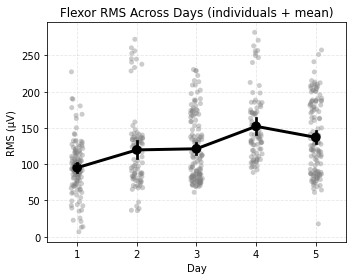

In [4]:
df = pd.read_csv("/Volumes/LaCie/ResearchProjects/Null_Space_EMG/preprocessing/EMG_features_per_trial.csv")

plt.figure(figsize=(5,4))
sns.stripplot(
    data=df, x="Day", y="RMS_flexors",
    color="gray", alpha=0.4, jitter=0.1, zorder=1
)
sns.pointplot(
    data=df, x="Day", y="RMS_flexors",
    estimator=np.mean, errorbar="se",
    join=True, markers="o", linestyles="-", color="black",
    scale=1.1, zorder=2
)
plt.title("Flexor RMS Across Days (individuals + mean)")
plt.xlabel("Day"); plt.ylabel("RMS (µV)")
plt.xticks([0,1,2,3,4], ["1","2","3","4","5"])
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()



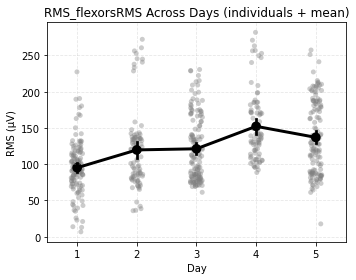

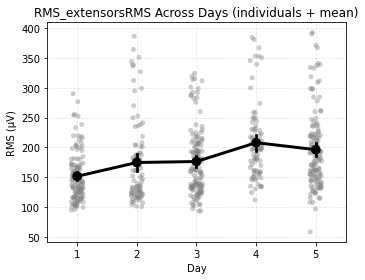

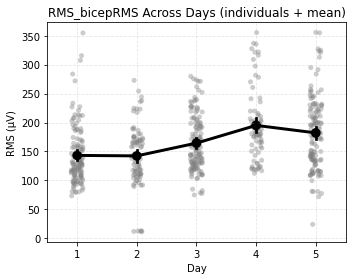

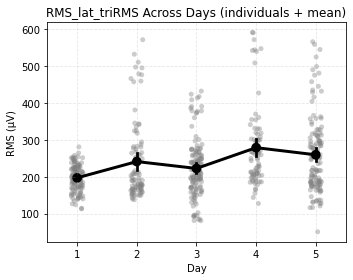

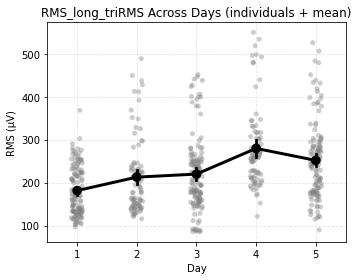

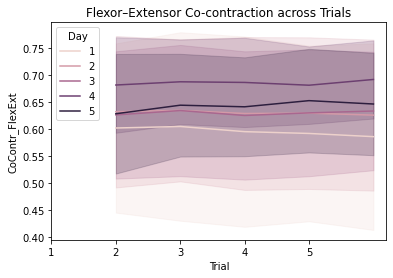

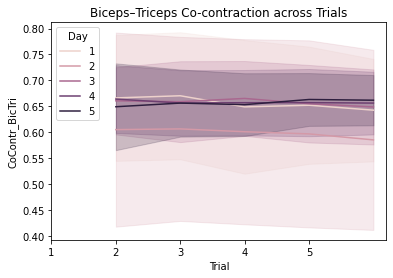

In [8]:
import seaborn as sns, matplotlib.pyplot as plt, pandas as pd
df = pd.read_csv("/Volumes/LaCie/ResearchProjects/Null_Space_EMG/preprocessing/EMG_features_per_trial.csv")

# Per-group RMS across days (averaged across trials)
for col in ["RMS_flexors","RMS_extensors","RMS_bicep","RMS_lat_tri","RMS_long_tri"]:
    plt.figure(figsize=(5,4))
    sns.stripplot(
        data=df, x="Day", y=col,
        color="gray", alpha=0.4, jitter=0.1, zorder=1
    )
    sns.pointplot(
        data=df, x="Day", y=col,
        estimator=np.mean, errorbar="se",
        join=True, markers="o", linestyles="-", color="black",
        scale=1.1, zorder=2
    )
    plt.title(col + "RMS Across Days (individuals + mean)")
    plt.xlabel("Day"); plt.ylabel("RMS (µV)")
    plt.xticks([0,1,2,3,4], ["1","2","3","4","5"])
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()


# Pairwise co-contraction across trials
sns.lineplot(data=df, x="Trial", y="CoContr_FlexExt", hue="Day", estimator=np.mean, ci="sd")
plt.title("Flexor–Extensor Co-contraction across Trials")
plt.xticks([0,1,2,3,4], ["1","2","3","4","5"])
plt.show()

sns.lineplot(data=df, x="Trial", y="CoContr_BicTri", hue="Day", estimator=np.mean, ci="sd")
plt.title("Biceps–Triceps Co-contraction across Trials")
plt.xticks([0,1,2,3,4], ["1","2","3","4","5"])
plt.show()


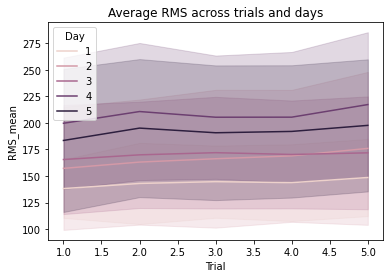

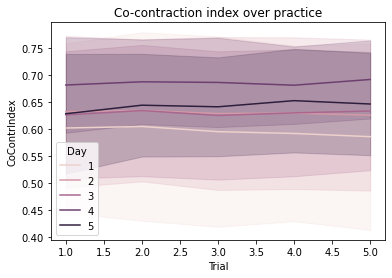

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("/Volumes/LaCie/ResearchProjects/Null_Space_EMG/preprocessing/EMG_features_per_trial.csv")

# e.g., plot RMS_mean across trials (proxy for effort)
sns.lineplot(data=df, x="Trial", y="RMS_mean", hue="Day", estimator=np.mean, ci="sd")
plt.title("Average RMS across trials and days")
plt.show()


# co-contraction index (motor efficiency)
sns.lineplot(data=df, x="Trial", y="CoContrIndex", hue="Day", estimator=np.mean, ci="sd")
plt.title("Co-contraction index over practice")
plt.show()
